Virtual Acoustics and Immersive Audio Workshop - CCRMA Stanford University  
24.07.25 - Orchisama Das, Gloria Dal Santo
  
### L04: Differentiable Artificial Reverberation

In this assignment we will 
- Create a Differentiable Feedback Delay Network (DiffFDN)
- Implement the Loss functions (if you don't have time, you can use those implemented in `flamo.optimize.loss`)
- Load the target RIR and construct a Dataset from it 
- Train the DiffFDN and plot the result and the training/validation loss 

For this assignment you'll be using [FLAMO library](https://github.com/gdalsanto/flamo).  
More specifically, we'll be using classes from 
- `flamo.processor.dsp` and `flamo.processor.system` to build the DiffFDN
- `flamo.optimize.dataset`for the dataset and dataloader 
- `flamo.optimize.trainer` for the train and validation steps   

If you want to use the pretrained parameters, set to True the `is_pretrained` variable in the imports 


In [1]:
# --- Imports ---
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from pathlib import Path
from flamo.optimize.loss import edr_loss
from flamo.optimize.dataset import Dataset, load_dataset
from flamo.optimize.trainer import Trainer
from room_acoustics.fdn import DifferentiableFeedbackDelayNetwork
from room_acoustics.plot import plot_time_domain, plot_spectrogram
from utils import audioread, find_onset
from scipy.signal import resample_poly

torch.set_default_dtype(torch.float32)

#### 1. Create a Differentiable Feedback Delay Network


- 1.1 Head to `room_acoustics.fdn`, you will find a partially coded class `DifferentiableFeedbackDelayNetwork`. Similarly to the example provided in [flamo](https://github.com/gdalsanto/flamo/blob/c88eb72cb929c6d95e12ce7b103d0de697654e11/examples/e8_fdn.py#L32C5-L32C16), define the different modules that constitute the FDN. 
- 1.2 In the cell below, create one instance of the DiffFDN.
- 1.3 Normalize the energy of the recursive part of the FDN. You can do this by calling the `normalize_late_energy` method.
- 1.4 Get the impulse response of the system by calling the `get_time_response` of the class's shell object. 
- 1.5 Plot it in time domain and its spectrogram. Convolve it with a dry signal to hear how a randomly initialized FDN can sound like. 

Note: The impulse response is a tensor of shape (batch_size, nfft, output_channels), following the FLAMO convention.
When calling `get_time_response`, output_channels = 1 and batch_size = 1. However, to plot it correctly we need to squeeze it

/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/workshop/vaia-25/lectures/git/VAIAWorkshop25Public/src/room_acoustics/fdn.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.delay_lengths = torch.tensor(delay_lengths)


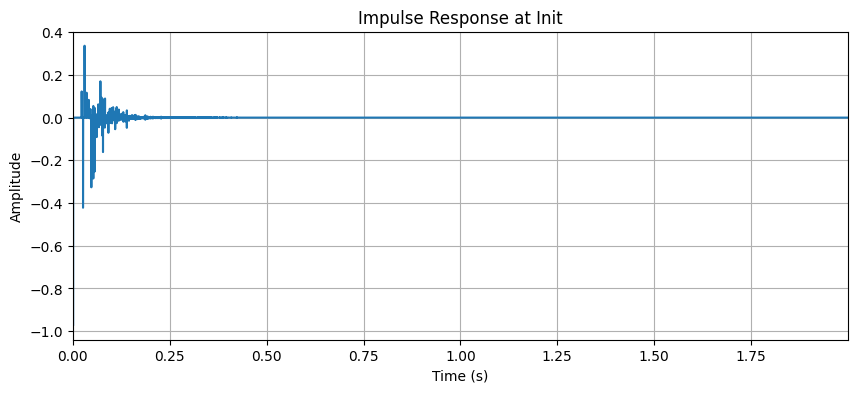

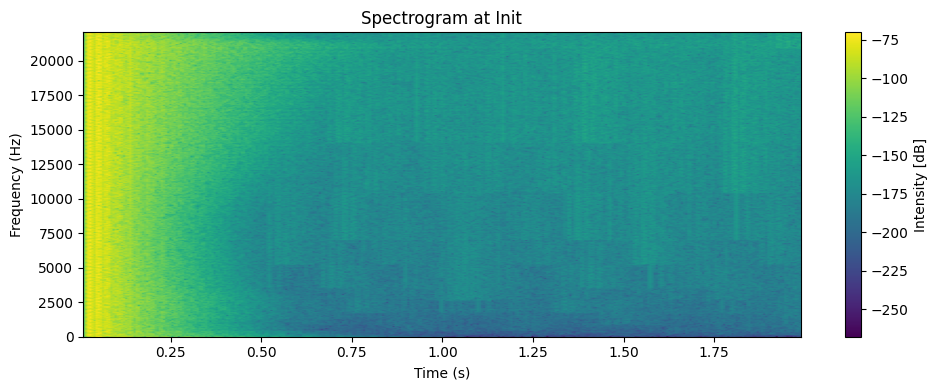

In [2]:
# --- Construct the Differentiable FDN ---
delay_lengths = torch.tensor([997, 1153, 1327, 1559, 1801, 2099])
N = len(delay_lengths)
fs = 44100
nfft = 2 * fs

# create one instance of the DiffFDN
diffFDN = DifferentiableFeedbackDelayNetwork(
    delay_lengths=delay_lengths,
    nfft=nfft,
    fs=fs,
)

# it is good practice to normalize the energy of the FDN, ideally to match the target energy of the RIR
diffFDN.normalize_late_energy(target_energy=1.0)

# for easiness, let's rename the shell object 
model = diffFDN.model

ir = model.get_time_response()
ir = ir.squeeze().numpy()

plot_time_domain(ir, fs=fs, title="Impulse Response at Init")
plot_spectrogram(ir, fs=fs, title="Spectrogram at Init", clim=[None, None])

rec_path = Path('..') / 'data' / 'Drums.wav'
rec, rec_fs = audioread(str(rec_path))
if rec_fs != fs:
    # resample the recording to match the FDN's sampling rate
    rec = resample_poly(rec, fs, rec_fs)
# convert rec to a torch tensor with appropriate shape and dtype
rec_tensor = torch.tensor(rec[:ir.shape[0]], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
# pass through the model and detach the result
processed_audio = model(rec_tensor).squeeze().detach().numpy()
# Play the processed audio
ipd.display(ipd.Audio(processed_audio, rate=fs))


#### 2. Load Target RIR and Create Dataloader

- 2.1 Load the target RIR `data/arni_35.wav` and check that its sampling rate matches the model's sampling rate (good practice).
- 2.2 Remove the onset from the target RIR to align it properly. Alternatively you can design the onset delay to be equivalent to the target's onset. 
- 2.3 Match the length of the target RIR to the model's impulse response and normalize its energy. By default the model IR's length is equivalent to`nfft`, number of fft points.
- 2.4 Create an impulse input and use it to construct a dataset for training.
- 2.5 Generate training and validation dataloaders from the dataset.


In [3]:
# --- Load Target RIR and Create Dataloader ---

# Load target RIR

# Load the target RIR from a file - call it `target_rir_np`
target_path = Path("..") / "data" / "arni_35.wav"
target_rir_np, fs_target = audioread(str(target_path))

# Check that sampling rate matches the model's sampling rate
assert fs_target == fs, "Sampling rate of target RIR does not match model's sampling rate."

# Find and remove onset 
onset_time = find_onset(target_rir_np).item()
target_rir_np = np.pad(target_rir_np[onset_time:], (0, onset_time))

# Match length to model IR and normalize energy
ir_len = nfft
# We need to make a Torch tensor from the target RIR
target_rir = torch.tensor(target_rir_np[:ir_len], dtype=torch.float32).reshape(1, -1, 1)
target_rir = target_rir / torch.sqrt(torch.sum(target_rir ** 2))

num = 128  # Number of examples in the dataset
batch_size = 1  # Batch size for training - here there is no need to increase it (no SGD)
# Create impulse input for dataset
input_imp = torch.zeros(num, ir_len, 1)
input_imp[:, 0, :] = 1

# Generate dataset and loaders
dataset = Dataset(
    input=input_imp,
    target=target_rir,
    expand=num,
)
train_loader, valid_loader = load_dataset(dataset, batch_size=batch_size)


#### 3. Train the Differentiable FDN or Load Pretrained Model

- 3.1 Complete the sparsity loss class that will be used to promote temporal density
- 3.2 Configure the trainer class. Add the losses using the `register_criterion` method, which will require you to provide a weight `alpha` and whether or not the loss requires access to the model's parameters (this will be set to True when using the sparsity loss, since it need to access to the feedback matrix). To optimize the attenuation filters use the `edr_loss` available in flamo. The EDR loss matches the Energy Decay Relief between the generated and target impulse responses
- 3.3 Start the training process with the prepared dataloaders.

The training will run for the specified number of epochs, saving checkpoints during the process. After every epoch the trainer will print the training and validation losses. 

**Note**: Training can take several minutes depending on your hardware (On Mac M1 it takes ~15 mins). The model will learn to match the target RIR's acoustic characteristics. If you have trouble training the model due the limitations of the available computing power, you can load the weights of a pretrained model from `data/checkpoints/.`. Set `is_pretrained`to True in that case. 

In [4]:
# --- Load Pretrained Model or Start Training ---

# Implement the losses 
class sparsity_loss(nn.Module):
    r"""
    Calculates the sparsity loss for a given model.

    The sparsity loss is calculated based on the feedback loop of the FDN model's core.
    It measures the sparsity of the feedback matrix A of size (N, N).
    Note: for the loss to be compatible with the class :class:`flamo.optimize.trainer.Trainer`, it requires :attr:`y_pred` and :attr:`y_target` as arguments even if these are not being considered.
    If the feedback matrix has a third dimension C, A.size = (C, N, N), the loss is calculated as the mean of the contribution of each (N,N) matrix.

    .. math::

        \mathcal{L} = \frac{\sum_{i,j} |A_{i,j}| - N\sqrt{N}}{N(1 - \sqrt{N})}

    For more details, refer to the paper `Optimizing Tiny Colorless Feedback Delay Networks <https://arxiv.org/abs/2402.11216>`_ by Dal Santo, G. et al.

    **Arguments**:
        - **y_pred** (torch.Tensor): The predicted output.
        - **y_target** (torch.Tensor): The target output.
        - **model** (nn.Module): The model containing the core with the feedback loop.

    Returns:
        torch.Tensor: The calculated sparsity loss.
    """

    def forward(self, y_pred: torch.Tensor, y_target: torch.Tensor, model: nn.Module):
        # This is how we access the feedback loop's mixing matrix
        core = model.get_core()
        A = core.branchA.feedback_loop.feedback.mixing_matrix.map(
            core.branchA.feedback_loop.feedback.mixing_matrix.param
        )
        N = A.shape[-1]
        #### WRITE YOUR CODE HERE ####
        # Calculate the sparsity loss
        return -(torch.sum(torch.abs(A)) - N * np.sqrt(N)) / (N * (np.sqrt(N) - 1))
    
is_pretrained = True # Set to True if you want to load a pretrained model instead of training from scratch
if not is_pretrained:
    print("Starting training from scratch.")
    # Initialize training process
    max_epochs = 20
    alpha = [2.0, 1.0]
    
    #### WRITE YOUR CODE HERE ####
    # Create the trainer class 
    trainer = Trainer(
        model,
        max_epochs=20,
        lr=1e-2,
        step_size=10,
        patience_delta=1e-6,
        train_dir=str(Path("../data")),
    )
    alpha = [1.0, 2.0]
    # Register the losses using `trainer.register_criterion` you have to do it twice, once for the sparsity loss and once for the EDR loss
    trainer.register_criterion(sparsity_loss(), alpha=alpha[0], requires_model=True)
    trainer.register_criterion(edr_loss(), alpha=alpha[1])
    # Start training
    trainer.train(train_dataset=train_loader, valid_dataset=valid_loader)

if is_pretrained:
    # Find the latest checkpoint
    checkpoints = sorted(
        (Path("..") / "data" / "checkpoints").glob("*.pt"),
        key=lambda x: x.stat().st_mtime,
    )
    if checkpoints:
        latest_checkpoint = checkpoints[-1]
        print(f"Loading model from {latest_checkpoint}")
        model.load_state_dict(
            torch.load(latest_checkpoint, map_location=torch.device("cpu"))
        )
        model.eval()
        print("Model loaded successfully.")
    else:
        print("No checkpoints found.")
        
    

Loading model from ../data/checkpoints/model_e19.pt
Model loaded successfully.


#### 4. Analyze Training Results and Compare with Target

- 4.1 If training was performed, visualize the training and validation losses over epochs to understand how well the model converged, and the relative 
- 4.2 Analyze the learned impulse response against the target by plotting them in time domain and their spectrogram. You could also run EDC analysis. 
- 4.3 Process an anechoic signal with the trained model.

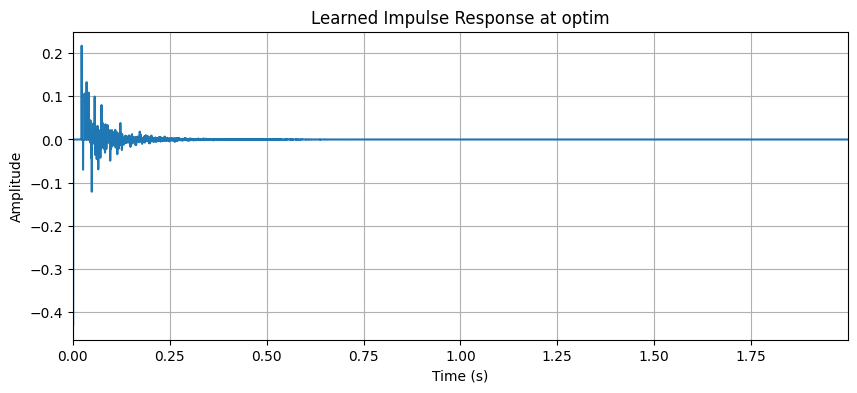

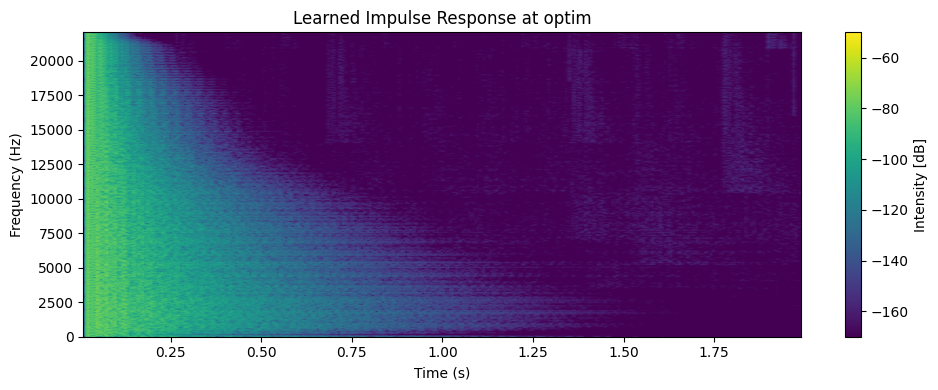

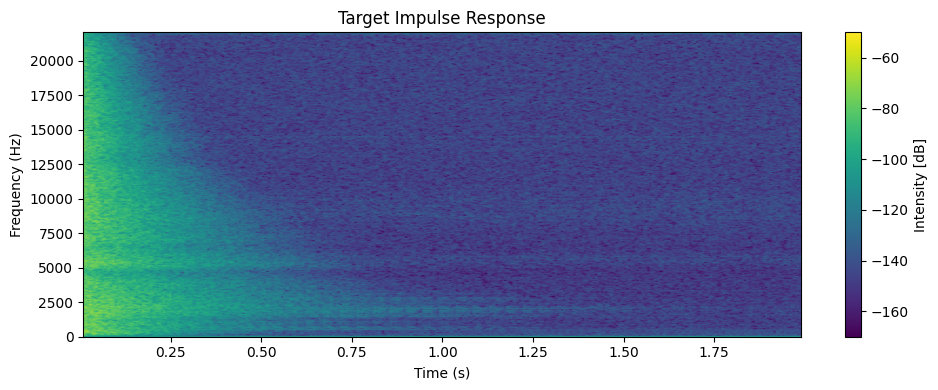

Convolution with FDN IR


Convolution with Target RIR


In [5]:
if not is_pretrained:
    # Create a plot for training loss
    plt.figure(figsize=(10, 6))
    for i, key in enumerate(trainer.train_loss_log.keys()):
        n_steps = len(trainer.train_loss_log[key])
        plt.plot(np.array(trainer.train_loss_log[key][:: n_steps // max_epochs]) * alpha[i], label=f"Train {key}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

    # Create a plot for validation loss
    plt.figure(figsize=(10, 6))
    for i, key in enumerate(trainer.valid_loss_log.keys()):
        n_steps = len(trainer.valid_loss_log[key])
        plt.plot(
            np.array(trainer.valid_loss_log[key][:: n_steps // max_epochs]) * alpha[i],
            label=f"Valid {key}",
        )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss")
    plt.legend()
    plt.show()

# Analyze the results
plot_time_domain(
    model.get_time_response().squeeze().numpy(),
    fs=fs,
    title="Learned Impulse Response at optim",
)

ir_out =  model.get_time_response().squeeze().numpy()
plot_spectrogram(
    ir_out / np.sqrt(np.sum(ir_out ** 2)),
    fs=fs,
    title="Learned Impulse Response at optim",
    clim=[-170, -50],
)

plot_spectrogram(
    target_rir.squeeze().numpy(),
    fs=fs,
    title="Target Impulse Response",
    clim=[-170, -50],
)


# pass through the model and detach the result
processed_audio = model(rec_tensor).squeeze().detach().numpy()
# Play the processed audio
ipd.display(ipd.Audio(processed_audio, rate=fs))

ir = model.get_time_response().squeeze().numpy()
ipd.display(ipd.Audio(ir, rate=fs))
print(f"Convolution with FDN IR")
ipd.display(ipd.Audio(np.convolve(ir, rec, 'full'), rate=fs))
print(f"Convolution with Target RIR")
ipd.display(ipd.Audio(np.convolve(target_rir.squeeze().numpy(), rec, 'full'), rate=fs))

